# Preambule

In [1]:
%autosave 180

Autosaving every 180 seconds


In [2]:
%%capture
import matplotlib.pyplot as plt
import numpy as np
import cv2

# try: cv2.setNumThreads(0)
# except: pass
from caiman import movie
import os
# %matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
from itertools import product
from collections import OrderedDict

from sys import path as syspath
syspath.append(os.path.expanduser("~/srdjan_functs/"))

from physio_def_1 import *
from matplotlib.colors import LogNorm

from numeric import *
from collections import Counter

# Importing

In [3]:
npzFiles = [
#     "local_data/Sandra/2020_01_14/Experiment45b/Experiment45b_1_Series006.npz",
#     "local_data/Sandra/2020_01_14/Experiment45b/Experiment45b_2_Series007.npz",
#     "local_data/Sandra/2020_01_14/Experiment45b/Experiment45b_3_Series008.npz"
    "local_data/testdir/Experiment38a_18_Series040.npz"
]
# npzFile = f"/Volumes/physio/team/slakrupnik/project/experiments/Sandra/{row.date}/{row.filename.split('_')[0]}/{row.filename}.npz"
metadata = pd.DataFrame([pd.read_csv(npzFile.replace("npz","txt")).loc[0] for npzFile in npzFiles])

In [4]:
metadata

,T,X,Y,freq,pxSize,pxUnit
0,256000,128,64,99.053494,2.09988,µm


In [5]:
metadata["T"]/metadata["freq"]/60 # minutes

0    43.074368
dtype: float64

In [6]:
if len(metadata)>1:
    assert metadata.X.std()==0
    assert metadata.Y.std()==0
    assert metadata.freq.std()/metadata.freq.mean()<1e-3

In [7]:
orig_images = []
for npzFile in npzFiles:
    npzData = np.load(npzFile)
    orig_images += [npzData["data"]]
#     plt.plot(npzData["time"])

m_orig = movie(np.vstack(orig_images).astype("float32"))

del orig_images

In [8]:
m_orig.fr = metadata.freq.mean()

In [9]:
metadata = pd.Series(metadata.iloc[0])

In [10]:
metadata["T"] = len(m_orig)
metadata["freq"] = m_orig.fr

In [11]:
metadata["T"]/metadata.freq/60

43.0743682536561

In [12]:
time = np.arange(len(m_orig)).astype(np.float32)/metadata.freq

In [13]:
print (time.max()/60)
allTrace = m_orig.mean((1,2))
Nsatur = np.sum(m_orig>m_orig.max()-1, axis=(1,2))

43.074198404947914


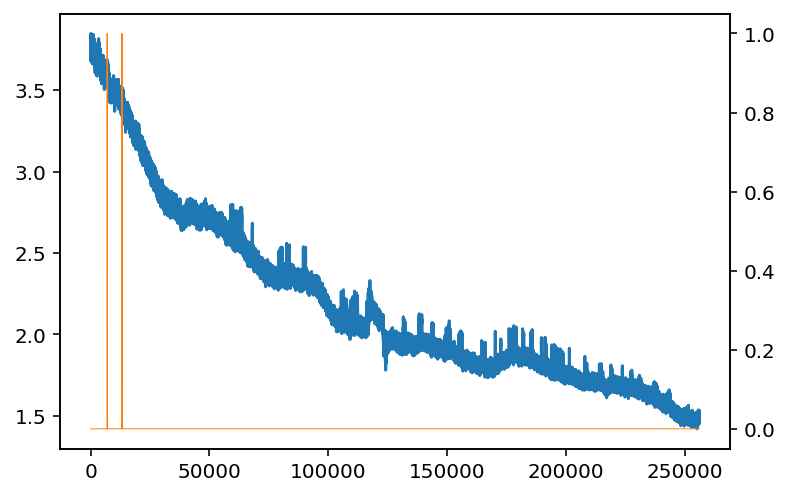

In [14]:
plt.plot(allTrace)
plt.twinx()
plt.plot(Nsatur,"C1",lw=.5)

In [15]:
# npoints = len(allTrace)
# plt.plot(rebin(allTrace,len(allTrace)//npoints))
# plt.twinx()
# plt.plot(rebin(Nsatur,len(Nsatur)//npoints,norm=False),"C1",lw=.5)

# average to save time and memory, especially if there are waves

In [18]:
metadata.freq

99.05349375157736

In [10]:
newFreq = 30
tWin = int(np.ceil(m_orig.fr/newFreq))
newFreq = m_orig.fr/tWin
newFreq,tWin

(24.76337343789434, 4)

In [11]:
print("New period will be %.1fms"%(1000./newFreq))

New period will be 40.4ms


In [12]:
m_resized = m_orig.resize(1,1,newFreq/m_orig.fr)*tWin

In [13]:
m_orig = m_resized.copy()
del m_resized

# First glimpse analysis

In [16]:
m_debleached = m_orig.debleach()

In [17]:
saveRes = OrderedDict()

In [18]:
saveRes.keys()

odict_keys([])

In [36]:
# from caiman.summary_images import local_correlations_fft
# from caiman.summary_images import local_correlations

In [37]:
# %%capture
# cfft =  local_correlations_fft(m_orig[:5000],eight_neighbours=True,swap_dim=False)

# %%capture
# c0 = m_orig[:5000].local_correlations(eight_neighbours=True,swap_dim=False)

# %%capture
# c00 = local_correlations(m_orig[:5000], eight_neighbours=True,swap_dim=False)

# np.abs(c0-cfft).max(), np.abs(c0-c00).max(), np.abs(cfft-c00).max()

# %matplotlib notebook

# fig, axs = plt.subplots(1,3,figsize=(10,3), sharey=True, sharex=True)
# for ax,im in zip(axs, [c00,c0,cfft]):
#     ax.imshow(im, vmin=-1, vmax=1, cmap="bwr")

In [19]:
%%capture
saveRes.update(OrderedDict([
    ("orig_cc", m_orig.local_correlations(eight_neighbours=True,swap_dim=False)),
    ("debleached_cc", m_debleached.local_correlations(eight_neighbours=True,swap_dim=False)),
    ("debleached_mean", m_debleached.mean(0)),
    ("debleached_std", m_debleached.std(0)),
]))

In [ ]:
%%capture
dm_debleached = np.diff(m_debleached,axis=0)
saveRes.update(OrderedDict([
    ("ddbl_mean", dm_debleached.mean(0)),
    ("ddbl_std", dm_debleached.std(0)),
    ("ddbl_cc", dm_debleached.local_correlations(eight_neighbours=True,swap_dim=False)),
]))

In [ ]:
%%capture
dm_orig = np.diff(m_debleached,axis=0)
del dm_debleached, m_debleached

saveRes.update(OrderedDict([
    ("dOrig_mean", dm_orig.mean(0)),
    ("dOrig_std", dm_orig.std(0)),
    ("dOrig_cc", dm_orig.local_correlations(eight_neighbours=True,swap_dim=False)),
]))

In [ ]:
# plt.imshow(np.abs(saveRes["debleached_cc"]-saveRes["orig_cc"]))
# plt.colorbar()
# plt.imshow(np.abs(saveRes["debleached_cc"]/(saveRes["orig_cc"]+1e-3)-1), norm=LogNorm())
# plt.colorbar()
# plt.imshow(saveRes["orig_cc"])
# plt.colorbar()
# plt.imshow(saveRes["debleached_cc"])
# plt.colorbar()

In [ ]:
ar = metadata.X/metadata.Y
figw = 14
fig, axs = plt.subplots(3,3,figsize=(figw,(ar+.1)*figw), sharex=True, sharey=True)

for ax,mt in zip(axs.flat,[
    "debleached_mean", "debleached_std", "debleached_cc",
    "dOrig_mean", "dOrig_std", "dOrig_cc",
    "ddbl_mean", "ddbl_std", "ddbl_cc",
                          ]):
    ax.set_title(mt)
    try:
#         m = eval(mt)
        m = saveRes[mt]
    except:
        continue
    if np.any(m<0) or 'cc' in mt:
        im = ax.imshow(m,cmap="bwr",vmax=np.abs(m).max(),vmin=-np.abs(m).max())
    else:
        im = ax.imshow(m,norm=LogNorm())
    plt.colorbar(im,ax=ax,shrink=.7,orientation="horizontal")
fig.tight_layout()

In [ ]:
n,s = 3,.55
blurredWeights = cv2.GaussianBlur(saveRes["dOrig_std"],(n,n),s)
plt.imshow(blurredWeights,norm=LogNorm())

# Define ROIs

In [ ]:
# some definitions
def climb(x,blurredWeights,diag=True):
    dims = blurredWeights.shape
    # x = (60,60)
    x = x+(blurredWeights[x[0],x[1]],)
    xs = [x]
    # vs = pd.DataFrame(columns=["i","j","v"])
    for i in range(100):
        vs = []
        for di,dj in product([-1,0,1],[-1,0,1]):
            if not diag:
                if di*dj!=0: continue
            i,j = x[0]+di,x[1]+dj
            if i<0 or i>=dims[0] or j<0 or j>=dims[1]:
#                 print ("skipping")
                continue
        #     vs = vs.append({"i":i,"j":j,"v":blurredWeights[i,j]},ignore_index=True)
            vs += [(i,j,blurredWeights[i,j])]

        x1 = vs[np.argmax(vs,axis=0)[-1]]
        if x1[-1]<=x[-1]:
            break
        else:
            x = x1
            xs += [x]
    return x[:2]

def crawlDict(image, th=0, diag=False):
    A_ = [(i,j)+climb((i,j),image,diag=diag) for i,j in product(range(image.shape[0]),range(image.shape[1])) if image[i,j]>th]
    B_ = OrderedDict()
    for (i0,j0,i1,j1) in A_:
        if (i1,j1) not in B_:
            B_[(i1,j1)] = []
        B_[(i1,j1)] += [(i0,j0)]
    return B_

In [ ]:
def edges2nodes(x,start=0,direction=1):
    if np.array(x[0]).shape != (2,2):
        x = [(el[:2],el[2:]) for el in x]
    nodes = list(x[start][::direction])

    for i in range(len(x)-1):
        nexts = [edge for edge in x if (edge[0]==nodes[-1] or edge[1]==nodes[-1])]
        for cand in np.unique(sum(nexts,()),axis=0):
            if tuple(cand) not in nodes:
                nodes += [tuple(cand)]
    return nodes

In [ ]:
from scipy.stats import gaussian_kde
gkde = gaussian_kde(blurredWeights.flatten())
h,edges,_ = plt.hist(blurredWeights.flatten(),100,histtype="step",density=True);
bincenters = (edges[:-1]+edges[1:])/2
gkde_vals = gkde.evaluate(bincenters)
plt.plot(bincenters,gkde_vals)
th = bincenters[list(crawlDict(-gkde_vals.reshape(-1,1)+gkde_vals.max()+1,).keys())[1][0]-2]
# plt.hist(stdDimg.flatten(),50,histtype="step");
# th = 1.4#e[np.where(np.diff(np.diff(h)<0))[0][0]+1:][:2].mean()
plt.axvline(th,color="r")



In [ ]:
testImage = blurredWeights[:,:]

In [ ]:
B = crawlDict(testImage,th=th)

In [42]:
dround = np.vstack([(-1,-1),(-1, 1),( 1, 1),( 1,-1),(-1,-1)])
# tmp = [(dx,dy) for dx,dy in dround]
# tmp += [tmp[0]]
dedges = []
for el in zip(dround[:-1],dround[1:]):
    el = np.array(el)+1
    el = np.vstack(sorted(el,key=np.linalg.norm))-1
#     dedges += [tuple(map(tuple,el*.5))]
    dedges += [el*.5]

dedges = np.stack(dedges)

In [43]:
toBreak = False
edgeID = OrderedDict()
for k in B:
    for x,y in B[k]:
        edges = dedges.copy()
        edges[...,0] += x
        edges[...,1] += y
        for edge in edges.reshape((-1,4)):
            edge = tuple(edge)
            if edge not in edgeID:
                edgeID[edge] = []
            edgeID[edge] += [k]
            if len(edgeID[edge])==2 and edgeID[edge][0]==edgeID[edge][1]:
                del edgeID[edge]


In [44]:
invEdgeID = OrderedDict()
for k in edgeID:
    for p in edgeID[k]:
        if p not in invEdgeID:
            invEdgeID[p] = []
        invEdgeID[p] += [k]

In [46]:
ks = list(B.keys())

In [47]:
neighborsMap = {k:[] for k in ks}
for edge in edgeID:
    if len(edgeID[edge])>1:
        for e1,e2 in product(edgeID[edge],edgeID[edge]):
            if e1==e2: continue
            if e2 not in neighborsMap[e1]:
                neighborsMap[e1] += [e2]

In [48]:
# remove rois smaller than Npx_min and without neighbors
Npx_min = 4
toRemove = []
for k in ks:
    n_pixels = len(B[k])
    n_neighbors = len(neighborsMap[k])
    if n_pixels<Npx_min and n_neighbors==0:
        toRemove += [k]
#         del B[k]
# del ks

In [49]:
len(B), len(toRemove)

(285, 23)

In [50]:
for k in toRemove:
    del B[k]

In [51]:
# plt.figure(figsize=(7,8))
# ax = plt.subplot(111)
# ax.imshow(testImage.T,cmap="Greys",norm=LogNorm(),vmax=testImage.max()*10)

# ks = list(B.keys())[::1]
# for ik,k in enumerate(ks):
#     c = plt.plot([])[0].get_color()
# #     for el in B[k]:
# #         plt.plot([el[0],k[0]],[el[1],k[1]],lw=.3,c=c)
# #     for el in invEdgeID[k]:
# #         x,y = np.array(el).reshape((2,2)).T
# #         plt.plot(x,y,"k")
#     x,y = k # np.mean(B[k],axis=0)
#     plt.plot(x,y,"o",ms=1*len(B[k])**.5,mfc="none",c=c)
# for el in np.unique(sum([invEdgeID[k] for k in ks],[]), axis=0):
#     x,y = np.array(el).reshape((2,2)).T
#     plt.plot(x,y,"k",lw=.5)
# ax.set_aspect("equal")

# Define dataframe

In [52]:
C = pd.DataFrame([],index=np.arange(len(B)))
C["peak"] = B.keys()
C["pixels"] = B.values()
C["center"] = [np.mean(C.loc[i,"pixels"], axis=0) for i in C.index]
C["size"] = list(map(len,C["pixels"]))
cnt = Counter(C['size'])
cnt = OrderedDict([(k,cnt[k]) for k in sorted(cnt.keys())])
len(C)

262

<ErrorbarContainer object of 3 artists>

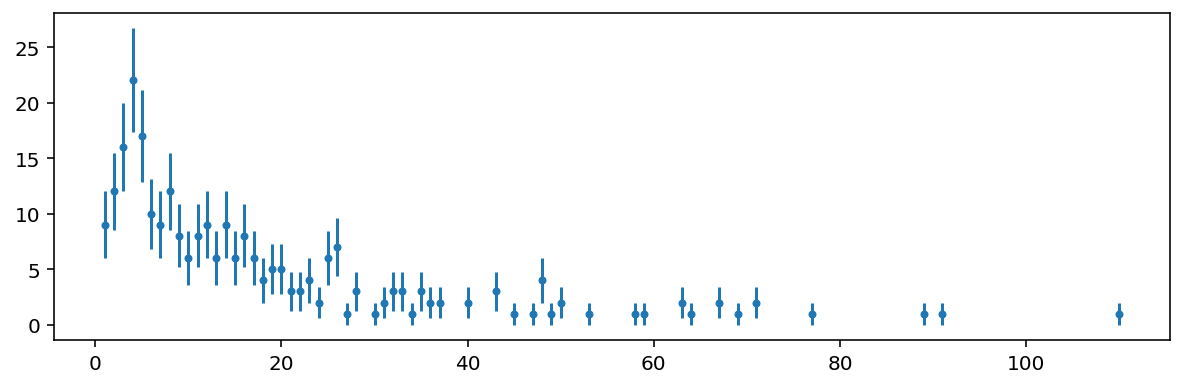

In [53]:
plt.figure(figsize=(10,3))
# plt.bar(cnt.keys(),cnt.values())
plt.errorbar(cnt.keys(),cnt.values(),np.array(list(cnt.values()))**.5,ls="none",marker=".")

In [54]:
from bidict import bidict
peak2idx = bidict([(peak,j) for j,peak in zip(C.index,C.peak)])
C["neighbors"] = [[peak2idx[p2] for p2 in neighborsMap[p1]] for p1 in C["peak"]]
C["Nneighbors"] = C["neighbors"].apply(len)
C["edges"] = [invEdgeID[p] for p in C.peak]

In [55]:
bd = []
for j in C.index:
    x = edges2nodes(C["edges"][j])
#     plt.plot(*np.array(x).T,marker=".")
    x = [x[i] for i in [0]+list(np.where(np.diff(np.diff(x,axis=0),axis=0).T[0]!=0)[0]+1)]
#     plt.plot(*np.array(x).T,marker="o", mfc="none")
    bd += [x]

C["boundary"] = list(bd)
del bd

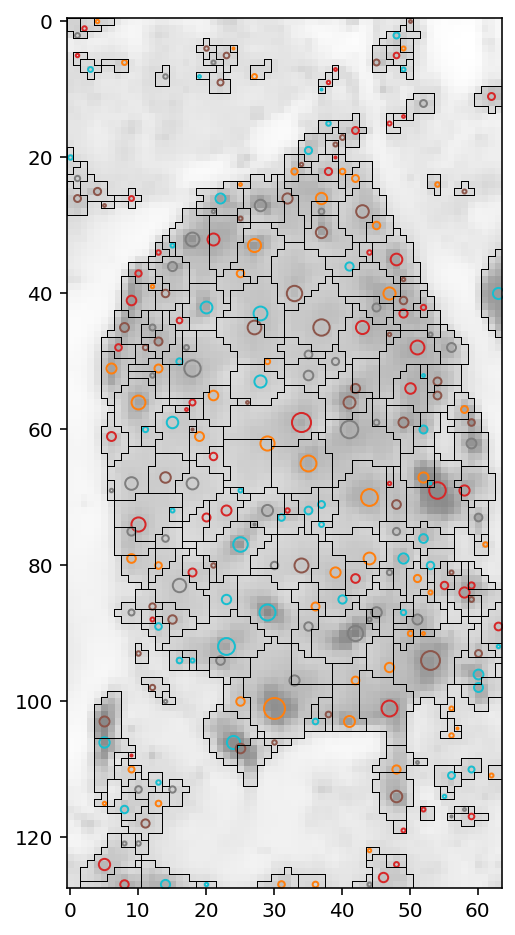

In [56]:
plt.figure(figsize=(7,8))
ax = plt.subplot(111)
ax.imshow(testImage.T,cmap="Greys",norm=LogNorm(),vmax=testImage.max()*10)

for i in C.sort_values("size",ascending=False).index[:]:
    c = plt.plot([])[0].get_color()
    x,y = C.loc[i,"peak"]#np.mean(C.loc[i,"pixels"],axis=0)
    plt.plot(x,y,"o",mfc="none",ms=C.loc[i,"size"]**.5)
#     plt.text(x,y,i)

for el in np.unique(sum(C["edges"],[]), axis=0):
    x,y = np.array(el).reshape((2,2)).T
    plt.plot(x,y,"k",lw=.5)
    

ax.set_aspect("equal")

In [57]:
def trace(pxs):
    return m_orig[(slice(None),)+tuple(np.array(pxs).T)].mean(axis=1)

In [58]:
traces = []
for i in C.index:
    traces += [trace(C.loc[i,"pixels"])]

In [59]:
C["trace"] = list(traces)

In [60]:
C["peakValue"] = [testImage[p] for p in C.peak]

In [61]:
# plt.hist(C.peakValue,100)

# Filter (detrend) ROIs

In [62]:
from numba import jit, prange

In [63]:
@jit 
def percFilter(x_,perc,filterSize):
    if filterSize%2==0:
        raise ValueError("filter size needs to be odd number")
    delta = filterSize//2
    out = np.zeros_like(x_)
    x_ = np.hstack((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in prange(len(out)):
        out[i] = np.percentile(x_[i:i+filterSize],perc)
    return out
@jit 
def runningAverage(x_,filterSize):
    if filterSize%2==0:
        raise ValueError("filter size needs to be odd number")
    delta = filterSize//2
    out = np.zeros_like(x_)
    x_ = np.hstack((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in prange(len(out)):
        out[i] = np.nanmean(x_[i:i+filterSize])
    return out
@jit 
def runningStd(x_,filterSize):
    if filterSize%2==0:
        raise ValueError("filter size needs to be odd number")
    delta = filterSize//2
    out = np.zeros_like(x_)
    x_ = np.hstack((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in prange(len(out)):
        out[i] = np.nanstd(x_[i:i+filterSize])
    return out


In [126]:
# dt = .333
ironScale = 2.
wIron = int(ironScale*m_orig.fr)
if wIron%2==0:
    wIron += 1
print(wIron)
filterPars = (wIron,wIron,50.,2)

199


In [127]:
%%capture
lowPass(C["trace"][0],*filterPars)

In [128]:
time = np.arange(len(m_orig))/m_orig.fr

In [131]:
from general_functions import multi_map

In [132]:
def iterf(x_):
    return lowPass(x_,*filterPars)

C["slower_%g"%ironScale] = multi_map(iterf,C.loc[:,"trace"].values,processes=15)
# C["slower_%g"%ironScale] = [iterf(tr) for tr in C.loc[:,"trace"]]

In [133]:
C["faster_%g"%ironScale] = [C.loc[i,"trace"] - C.loc[i,"slower_%g"%ironScale] for i in C.index]

In [134]:
x = C.trace[0]

In [135]:
# percFilter(np.abs(x),50.,wIron)
mad2std = 1.4826

In [136]:
from scipy.stats import median_absolute_deviation

In [137]:
def iterf(x_):
    out = mad2std*percFilter(np.abs(x_),50.,5*wIron)
    out = runningAverage(out,5*wIron)
    return out

C["faster_%g_std"%ironScale] = multi_map(iterf,C["faster_%g"%ironScale].values,processes=15)

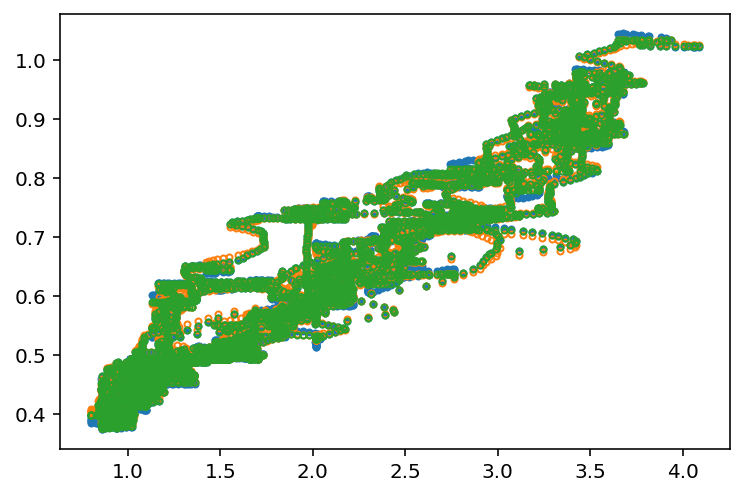

In [138]:
n = 30
plt.plot( C.loc[i,"slower_2"][::n], C.loc[i,"faster_2_std"][::n], ".")
plt.plot( C.loc[i,"slower_2"][::n], runningAverage(C.loc[i,"faster_2_std"], wIron*5 )[::n], ".-", mfc="none", lw=0 )
plt.plot( C.loc[i,"slower_2"][::n], percFilter(C.loc[i,"faster_2_std"], 50.,wIron*5 )[::n], ".-", mfc="none", lw=0 )

In [139]:
zscore = np.vstack(C.faster_2)/np.vstack(C.faster_2_std)

In [140]:
np.median(C.faster_2[0][:1000])

movie(-0.00199032, dtype=float32)

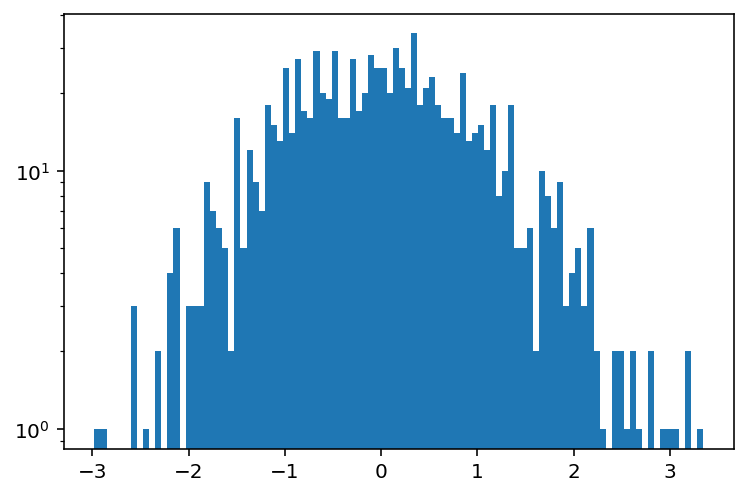

In [141]:
plt.hist(C.faster_2[0][:1000],100,log=True);

In [151]:
zth = 2
negRender = zscore<-zth
posRender = zscore>+zth

In [262]:
fltr = (C["size"]>40).values

In [263]:
fltr.sum()

27

In [264]:
%matplotlib inline

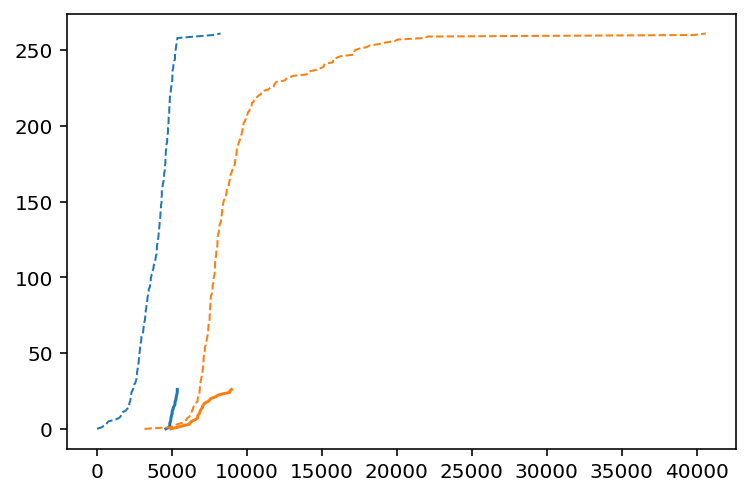

In [265]:
for x in [negRender,posRender]:
    x = x.sum(axis=1)
    c = plt.plot(sorted(x),np.arange(len(x)),"--",lw=1)[0].get_color()
    plt.plot(sorted(x[fltr]),np.arange(fltr.sum()),"-",c=c)

# plt.plot(sorted(), )#.mean()
# plt.plot(sorted(posRender.mean(axis=1)), np.arange(len(C)))#.mean()

In [266]:
# for x in [posRender,negRender]:
#     plt.hist(x.sum(axis=1),100, histtype="step",density=True);

In [267]:
iis = np.where(fltr)[0][np.argsort(-posRender.sum(axis=1)[fltr])]

In [268]:
# plt.figure(figsize=(7,8))
# ax = plt.subplot(111)
# ax.imshow(testImage.T,cmap="Greys",norm=LogNorm(),vmax=testImage.max()*10)

# for i in iis:
#     c = plt.plot([])[0].get_color()
#     x,y = C.loc[i,"peak"]#np.mean(C.loc[i,"pixels"],axis=0)
#     plt.plot(x,y,"o",mfc="none",ms=C.loc[i,"size"]**.5)
# #     plt.text(x,y,i)

# for el in np.unique(sum(C.loc[iis,"edges"],[]), axis=0):
#     x,y = np.array(el).reshape((2,2)).T
#     plt.plot(x,y,"k",lw=.5)
    

# ax.set_aspect("equal")

In [269]:
%matplotlib notebook

In [270]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

<IPython.core.display.Javascript object>


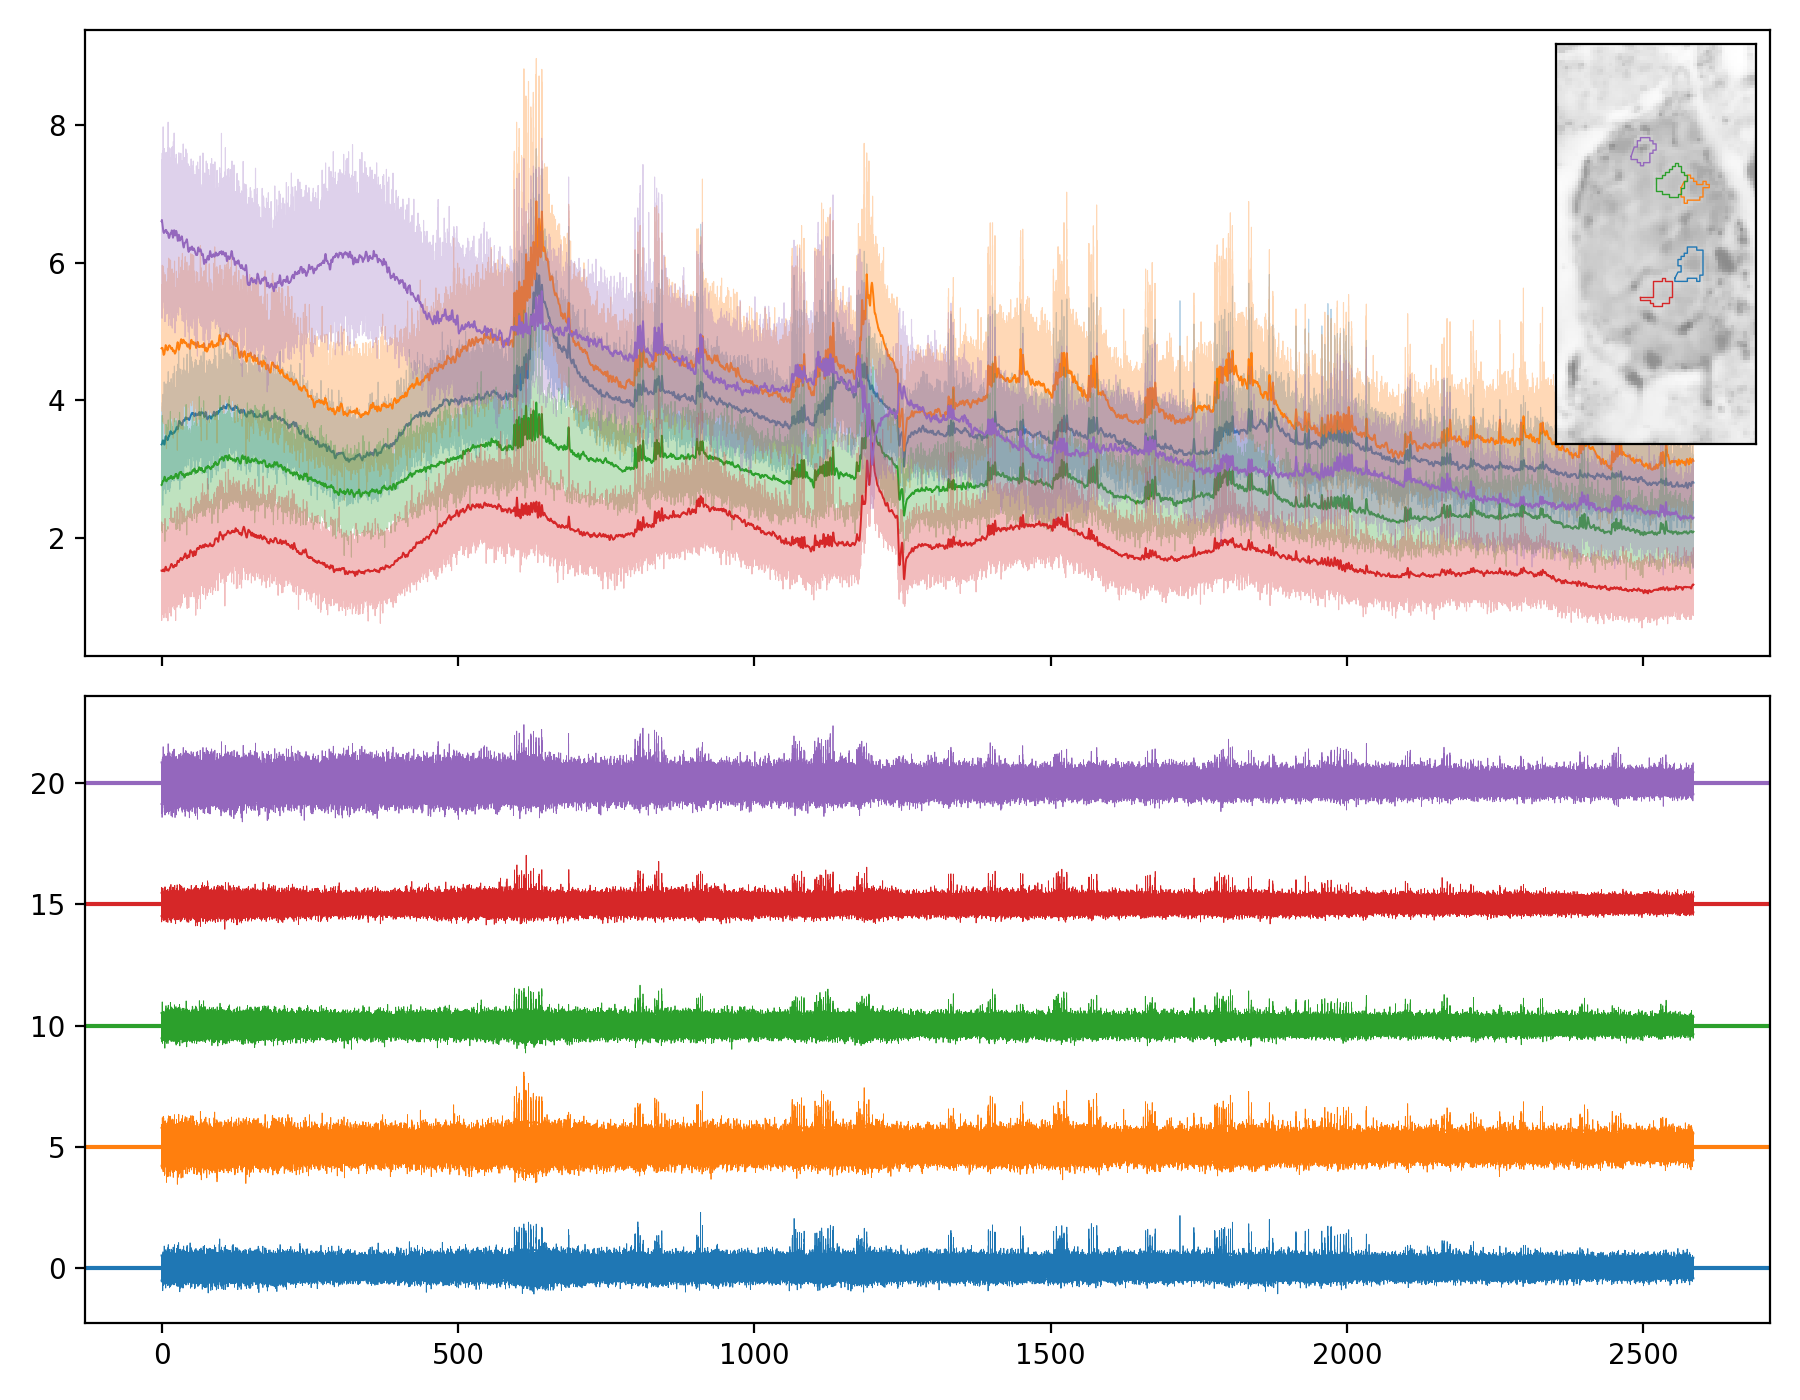

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [279]:
plt.close()
fig, axs = plt.subplots(2,1,figsize=(9,7), sharex=True)
ia = 0
n = 1
ns = 2

inax = inset_axes(axs[0],
                    width=1, # width = 30% of parent_bbox
                    height=2, # height : 1 inch
                    loc=1)
inax.imshow(testImage.T,cmap="Greys",norm=LogNorm(),vmax=testImage.max()*10)

for roi in iis[:5]:
    x  = C.loc[roi,"trace"]
    xf = C.loc[roi,"faster_%g"%ironScale]
    xsd= C.loc[roi,"faster_%g_std"%ironScale]
    xs = C.loc[roi,"slower_%g"%ironScale]
    c = "C%i"%ia
    axs[0].plot(time[::n],x [::n],c=c,lw=.4,alpha = .3)
    axs[0].plot(time[::n],xs[::n],c=c,lw=.7,alpha = 1)
    yoffset = 5*ia
    axs[1].plot(time[::n],xf[::n]+yoffset,label=roi,c=c,lw=.3)
    axs[1].plot(time[::n],+ns*xsd[::n]+yoffset,label=roi,c=c,lw=.7)
    axs[1].plot(time[::n],-ns*xsd[::n]+yoffset,label=roi,c=c,lw=.7)
    axs[1].axhline(yoffset,color=c)
    
#     x,y = C.loc[roi,"peak"]#np.mean(C.loc[i,"pixels"],axis=0)
#     inax.plot(x,y,"o",mfc="none",ms=C.loc[i,"size"]**.5/2,c=c,mew=.3)
    bb = list(C.loc[roi,"boundary"])
    bb += [bb[0]]
    x,y = np.array(bb).T
    inax.plot(x,y,c=c,lw=.5)
    ia += 1
    
    

plt.xticks([])
plt.yticks([])
fig.tight_layout()



In [275]:
# time.max()

<IPython.core.display.Javascript object>


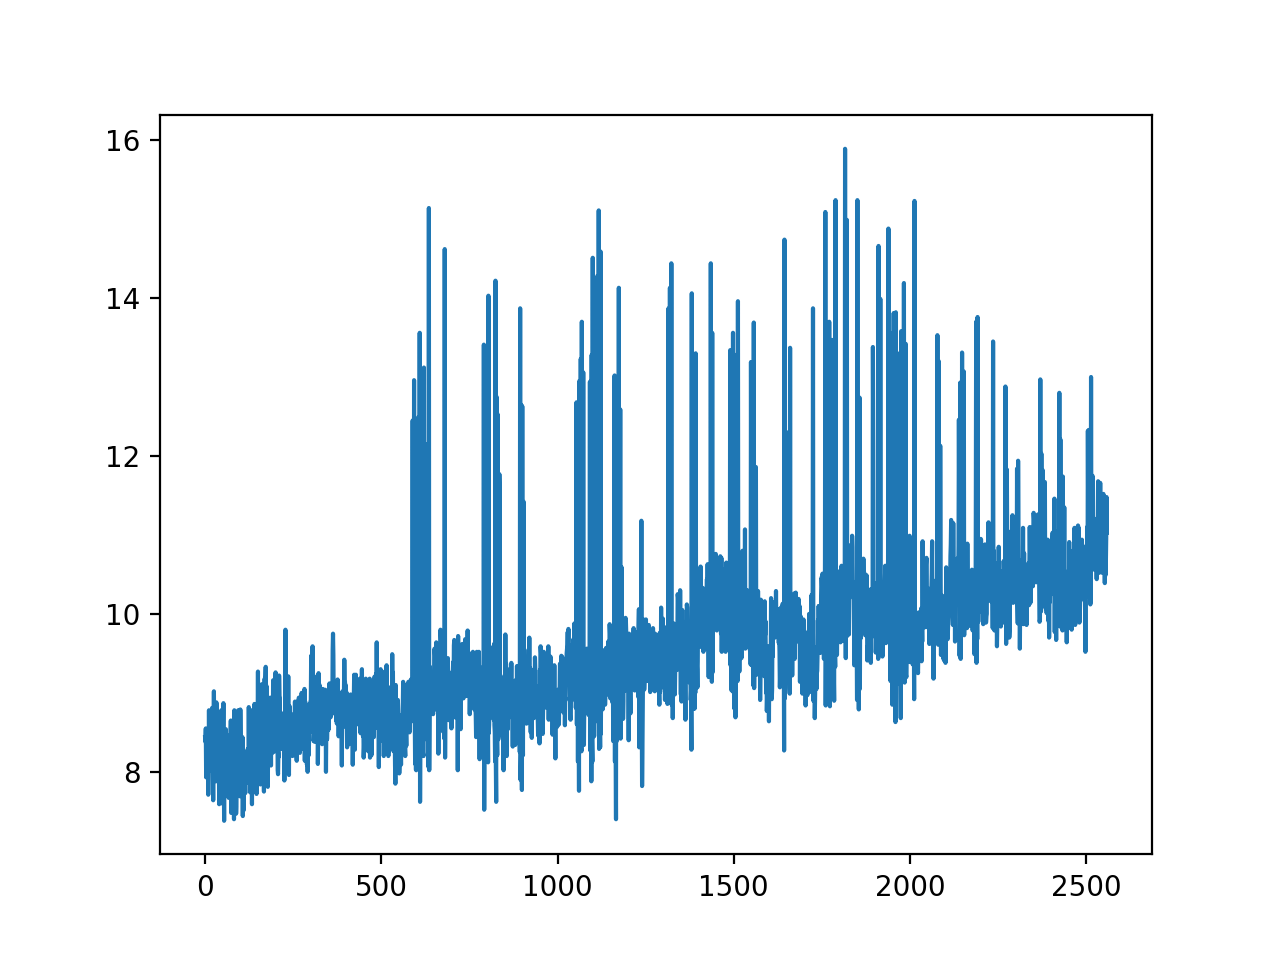

In [280]:
plt.figure()
plt.plot(rebin(posRender.sum(axis=0),100))

In [281]:
%matplotlib inline

# Save DataFrame

In [285]:
C.to_pickle(npzFile.replace(".npz",".pkl"))